# Tutorial on Computational Discovery of Cognitive Dynamics

This tutorial will lead you step-by-step into the world of computational discovery of cognitive dynamics.

In this tutorial you will learn to:

1. set up a data generation pipeline using a `Bandit` environment and a Q-Learning `Agent`

2. create your own RNN with different neural-network modules of which each approximates subsets of cognitive mechanisms and fit them to the generated data.

3. apply SINDy to replace the neural-network modules with equations for dynamical systems

The RNN will be trained on behavioral data given by the (synthetic) participant, i.e. input: (action, reward); target: (next action).

In order to tell whether the RNN and SINDy approximated the latent cognitive dynamics of the synthetic participant, we are going to compare the dynamics directly with each other in a plot.

In order to get everything going make sure to setup an environment with Python 3.11 and install the packages from the requirements. 

In [ ]:
import sys, os

# Get the current working directory (where the notebook is running)
dir_current = os.getcwd()

# Define the path to the project directory
dir_project = os.path.join(dir_current, "..")

# Add the project directoy to the Python path to make the subpackages visible
sys.path.append(dir_project)

import numpy as np
import torch

np.random.seed(42)
torch.manual_seed(42)

## 1. Data generation

Let's get started by setting up a two-armed bandit experiment and let a Q-Learning agent perform this task.

In such bandit tasks the participant has to choose between several options across many trials and receives a reward $r$ each time after selecting one of them.

This reward is based on a reward probability $p(r)$.

In some experiments the reward probabilities of the different options are fixed and in others they have a more dynamic nature.

In our case, the reward probabilities are going to change trial-by-trial randomly based on a drift rate $\sigma$ according to

$p(r;t+1) \leftarrow p(r;t) + d$ with $d \sim \mathcal{N}(0, \sigma)$,

where $d$ is the current drift.

Let's set up the environment first.

In [ ]:
from resources.bandits import BanditsDrift

In [ ]:
n_actions = 2
sigma = 0.2

environment = BanditsDrift(sigma=sigma, n_actions=n_actions)

Let's see how the reward probabilities of the arms change across trials

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n_trials = 200
reward_probabilities = np.zeros((n_trials, n_actions))

for index_trials in range(n_trials):
    reward_probabilities[index_trials] = environment.reward_probs
    environment.step(choice=0)

for index_action in range(n_actions):
    plt.plot(reward_probabilities[..., index_action], label=f'Option {index_action+1}')
plt.legend()
plt.xlabel(r'Trial $t$')
plt.ylabel(r'$p(r)$')
plt.show()

Great! After setting up the environment, we can now go on to set up our participant!

The agent's behavior is defined by its parameters. These parameters are set once in the beginning but you can also draw new parameters from a distribution for each new session (i.e. performing $t$ trials).

Let's begin with the simpler case first and keep the parameters fixed for all trials.

We are going to set up a simple Rescorla-Wagner model which has only a learning rate $\alpha$ and an inverse noise temperature $\beta_{reward}$.

In [ ]:
from resources.bandits import AgentQ

agent = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.3,
)

Let the agent perform now the task and track how the agent's internal believes change across trials!

In [ ]:
from resources.bandits import plot_session

values_reward = np.zeros((n_trials, n_actions))
choices = np.zeros((n_trials,), dtype=int)
rewards = np.zeros((n_trials, n_actions))
rewards_1d = np.zeros((n_trials))

environment.new_sess()
agent.new_sess()
for index_trials in range(n_trials):
    # track internal values of the agent and the reward probabilities
    values_reward[index_trials] = agent._state['x_value_reward']
    reward_probabilities[index_trials] = environment.reward_probs
    
    # perform the task
    choices[index_trials] = agent.get_choice()
    rewards[index_trials] = environment.step(choices[index_trials])
    rewards_1d[index_trials] = rewards[index_trials, choices[index_trials]]
    
    # update the belief of the agent based on the received reward
    agent.update(choices[index_trials], rewards[index_trials])

# plot everyting
plot_session(
    choices=choices,
    rewards=rewards_1d,
    timeseries=reward_probabilities,
    timeseries_name=r'Prob. $p(r)$'
    )

plot_session(
    choices=choices,
    rewards=rewards_1d,
    timeseries=values_reward,
    timeseries_name=r'Value $Q_{reward}$'
    )

The green and red ticks at the bottom mark whenever option 1 was chosen and rewarded/not rewarded and the ticks at the top do the same for option 2

Now that we have set up our experiment and the agent correctly, we can finally create the data generation pipeline!

In [ ]:
from resources.bandits import create_dataset

n_sessions = 256

dataset, experiments, _ = create_dataset(
    agent=agent,
    environment=environment,
    n_trials=n_trials,
    n_sessions=n_sessions,
)

You can take a look at the experiment results either in dataset (which is used for training the RNN) or in the experiments (which is a list of performed sessions; more human-readable)

In [ ]:
print('Inputs (prev. choice; prev. reward; session id):')
print(dataset.xs)

print('Targets (next choice):')
print(dataset.ys)

print('Experiment session:')
print('Choices:')
print(experiments[0].choices)
print('Rewards:')
print(experiments[0].rewards)

Now that we have our data, we can proceed to setup our RNN and train it!

## 2. Set up the RNN

In this section you are going to set up your very own RNN. 

This RNN will inherit from the `BaseRNN`-class which itself inherits from `pytorch.nn.Module`. This is the base class for neural networks in the `PyTorch` framework.

Therefore the RNN has to implement a `forward`-method which is used for prediction. Further, it needs submodules to perform computations. These submodules are stored in the dictionary ` submodules_rnn` with the key `x_ModuleName`. The start of the key `x_` means that we are talking here about a memory state variable of the RNN.

Here, we are going to implement the simplest version of such a RNN. This RNN will update only chosen value based on the reward and leaves the respectively other values untouched.

In [ ]:
from resources.rnn import BaseRNN

class RLRNN(BaseRNN):
    
    # set up a dictionary with initial values for each state in memory
    init_values = {
        'x_value_reward': 0.5,
    }
    
    def __init__(
        self,
        n_actions,
        **kwargs,
    ):   
        super(RLRNN, self).__init__(n_actions=n_actions, list_signals=['x_value_reward_chosen', 'c_action', 'c_reward'])
        
        # set up the submodules
        self.submodules_rnn['x_value_reward_chosen'] = self.setup_module(input_size=1)
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, _ = inputs
        
        for timestep, action, reward in zip(timesteps, actions, rewards):
            
            # Let's perform the belief update for the reward-based value of the chosen option
            # since all values are given to the rnn-module (independent of each other), the chosen value is selected by setting the action to the chosen one
            # if we would like to perform a similar update by calling a rnn-module for the non-chosen action, we would set the parameter to action=1-action.
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward_chosen',
                key_state='x_value_reward',
                action=action,
                inputs=reward,
                )

            # and keep the value of the not-chosen option unchanged
            next_value_reward_not_chosen = self.state['x_value_reward'] * (1-action)
            
            self.state['x_value_reward'] = next_value_reward_chosen + next_value_reward_not_chosen
            
            # Now keep track of this value in the output array
            logits[timestep] = self.state['x_value_reward']
            
            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
        
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        # self.state['x_value_reward'] = value_reward
        logits = self.post_forward_pass(logits, batch_first)
        
        return logits, self.get_state()

Now that we implemented our RNN, we can train it to see how well it fits the behavior of our synthetic participant.

In [ ]:
from resources.rnn_training import fit_model

model_rnn = RLRNN(n_actions=n_actions)
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=5e-3)

model_rnn, _, _ = fit_model(
    model=model_rnn,
    optimizer=optimizer_rnn,
    dataset_train=dataset,
    epochs=128,
    n_steps=16,
)

Let's see how our model behaves with respect to our synthetic participant

In [ ]:
from resources.bandits import AgentNetwork
from utils.plotting import plot_session

agent_rnn = AgentNetwork(model_rnn=model_rnn, n_actions=n_actions)

# get analysis plot
agents = {'groundtruth': agent, 'rnn': agent_rnn}

fig, axs = plot_session(agents, dataset.xs[0])
plt.show()

## 3. Applying SINDy to identify the trained cognitive dynamics

In this section we are going to replace the black-box RNN-modules with equations which cover - in the best case - the dynamics trained by the RNN.

Therefore, we are going to extract the memory state values of interest and fit one SINDy-model per RNN-module, which will then be replaced by its SINDy counterpart.

But before doing that, we have to define the exact architecture in the forms of dictionaries.

In [ ]:
# A list of all names of the RNN-modules which are computing the RNN's memory state
list_rnn_modules = ['x_value_reward_chosen']

# A list of all the control signals which are used as inputs to any of the RNN-modules
list_control_parameters = ['c_action', 'c_reward']

# Setup of the SINDy library
# Determines which terms are allowed as control inputs to each SINDy model in a dictionary.
# The key is the SINDy-model name (same as RNN-module), value is a list of allowed control inputs from the list of control signals     
library_setup = {
    'x_value_reward_chosen': ['c_reward'],
}

# Setup of the filtering condition
# Determines the filtering condition on which samples are selected as training samples for each SINDy-model.
# Example:
# Since each RNN-module processes all values at once (but independet from each other), we have to filter for the updates of interest.
# In the case of the reward-based value of the chosen option this means to use only the chosen items and not the non-chosen ones. 
# Therefore, we can set a filter condition to get rid of all value updates for non-chosen options.  
# The filter dictionary has the following structure:
# key -> the SINDy model name
# value -> triplet of values:
#   1. str: feature name to be used as a filter
#   2. numeric: the numeric filter condition
#   3. bool: remove feature from control inputs if not needed as input to the module
# Multiple conditions can also be given as a list of triplets, e.g. [['c_action', 1, True], ['c_reward', 0, False]]

filter_setup = {
    'x_value_reward_chosen': ['c_action', 1, True],
}

In [ ]:
from resources.sindy_utils import create_dataset as create_dataset_sindy
from resources.sindy_training import fit_model as fit_model_sindy
from resources.bandits import AgentSindy

agent_sindy = fit_model_sindy(
    rnn_modules=list_rnn_modules,
    control_parameters=list_control_parameters,
    agent=agent_rnn,
    data=environment,
    polynomial_degree=2,
    library_setup=library_setup,
    filter_setup=filter_setup,
    optimizer_threshold=0.05,
    optimizer_alpha=1,
    verbose=True,
)

You can see the resulting equation in one of the last output lines.

It should be similar to `(x_value_reward)[k+1] = 0.156 1 + 0.682 x_value_reward[k] + 0.895 c_reward[k]`.

It's maybe not reminding you directly of the classic Rescorla-Wagner model 

`(x_value_reward)[k+1] = ...`

`... = (x_value_reward)[k] + alpha_reward (c_reward[k] - (x_value_reward)[k])`

`... = (1 - alpha_reward) (x_value_reward)[k] + alpha_reward c_reward[k]`,

which is implemented by the synthetic participant, but let's break the identified equation down.

1. The constant `0.156 1` is applied equally to both arms without considering the any reward or current value. Therefore, it could also be left out (there's actually a way for doing that in the method `create_dataset_sindy` which we could utilize; later more about that).

2. The term `0.682 x_value_reward[k]` is actually pretty close to the classic model with `alpha_reward = 0.3`

3. The term `0.895 c_reward[k]` can be a bit irritating but makes total sense when you consider that the classic model has the scaling factor $\beta$ which is the inverse noise temperature with `beta_reward = 3`. Therefore, considering this scaling factor we get the parameter `0.895 c_reward[k] / beta_reward = 0.3 c_reward[k]`.

By interpreting the identified equation, we can see that the pipeline was able to fit the exact mechanism as implemented in the synthetic participant!

After initializing and fitting the SINDy-agent, we can now finally inspect whether all these steps resulted in well identified cognitive dynamics!

In [ ]:
# get analysis plot
agents = {'groundtruth': agent, 'rnn': agent_rnn, 'sindy': agent_sindy}

fig, axs = plot_session(agents, dataset.xs[0])
plt.show()

How does the fit look like? Does the equation which you received by SINDy makes any sense? If so, we discovered our first model of cognition!

We could now dive deeper into **computational discovery of cognitive dynamics**.

Try to set up a more complex version of the synthetic participant by adding e.g. a forget mechanism with `forget_rate=0.2`, and run the whole pipeline again. 

Forgetting is applied to the not-chosen reward-based value `x_value_reward`, where it resets the value gradually towards the initial value (0.5)  

What do you notice?

The fit should be decreased now. Mostly because the RNN does not have the ability to fit any dynamics to the not-chosen option.

Let's implement a more complex RNN which can cover this part as well.

# 4. Adding more RNN-modules

Here we are adding a RNN-module which handles the not-chosen reward-based values dynamically.

This should enable the RNN to learn a forgetting mechanism, which is present in the data.

In [ ]:
agent = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.3,
    forget_rate=0.2,
)

dataset, _, _ = create_dataset(
    agent=agent,
    environment=environment,
    n_trials=n_trials,
    n_sessions=n_sessions,
)

# SINDy configuration
# Add already here the new module and update the library and filter setup.
list_rnn_modules = ['x_value_reward_chosen', 'x_value_reward_not_chosen']

list_control_parameters = ['c_action', 'c_reward']

# The new module which handles the not-chosen value, does not need any additional inputs except for the value
library_setup = {
    'x_value_reward_chosen': ['c_reward'],
    'x_value_reward_not_chosen': [],
}

# Further, the new module should be applied only to the not-chosen values
filter_setup = {
    'x_value_reward_chosen': ['c_action', 1, True],
    'x_value_reward_not_chosen': ['c_action', 0, True],
}

In [ ]:
class RLRNN(BaseRNN):
    
    init_values = {
        'x_value_reward': 0.5,
    }
    
    def __init__(
        self,
        n_actions,
        list_signals,
        **kwargs,
    ):
        super(RLRNN, self).__init__(n_actions=n_actions, list_signals=list_signals)
        
        # set up the submodules
        self.submodules_rnn['x_value_reward_chosen'] = self.setup_module(input_size=1)
        self.submodules_rnn['x_value_reward_not_chosen'] = self.setup_module(input_size=0)
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, _ = inputs
                
        for timestep, action, reward in zip(timesteps, actions, rewards):
            
            # Let's perform the belief update for the reward-based value of the chosen option
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward_chosen',
                key_state='x_value_reward',
                action=action,
                inputs=reward,
                )

            # Now a RNN-module updates the not-chosen reward-based value instead of keeping it the same
            next_value_reward_not_chosen = self.call_module(
                key_module='x_value_reward_not_chosen',
                key_state='x_value_reward',
                action=1-action,
                inputs=None,
                )
            
            # keep track of the updated value in the memory state
            self.state['x_value_reward'] = next_value_reward_chosen + next_value_reward_not_chosen
            
            # Now keep track of this value in the output array
            logits[timestep] = self.state['x_value_reward']
            
            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
        
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        logits = self.post_forward_pass(logits, batch_first)
        
        return logits, self.get_state()

In [ ]:
model_rnn = RLRNN(n_actions=n_actions, list_signals=list_rnn_modules+list_control_parameters)
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=5e-3)

model_rnn, _, _ = fit_model(
    model=model_rnn,
    optimizer=optimizer_rnn,
    dataset_train=dataset,
    epochs=128,
    n_steps=16,
)

# set up RNN-agent
agent_rnn = AgentNetwork(model_rnn=model_rnn, n_actions=n_actions)

agent_sindy = fit_model_sindy(
    rnn_modules=list_rnn_modules,
    control_parameters=list_control_parameters,
    agent=agent_rnn,
    data=environment,
    polynomial_degree=2,
    library_setup=library_setup,
    filter_setup=filter_setup,
    optimizer_threshold=0.05,
    optimizer_alpha=1,
    verbose=True,
)

# Let's see how well the dynamics were fitted
agents = {'groundtruth': agent, 'rnn': agent_rnn, 'sindy': agent_sindy}
fig, axs = plot_session(agents, dataset.xs[0])
plt.show()

As you maybe noticed, the steps did not change dramatically thanks to the more-or-less seemless workflow.

The current RNN should also be able to handle asymmetric learning rates. Try it by setting the parameters `alpha_reward=0.6` and `alpha_penalty=0.3`. 

That way our synthetic participant will adapt its beliefs more when it receives a reward ($reward = 1$) compared to a penalty ($reward = 0$).

## 6. Adding hard-coded equations as RNN-modules and additional memory states

The equation for `x_reward_value_chosen` resembles basically the reward-prediction error.

The reward-prediction error is fairly well understood in cognitive science - also thanks to neuroimaging studies, which underlie the assumption about the classic mathematical form.

Therefore, the possible novel findings are quite limited here. 
The learning rate on the other hand is in many studies assumed to be a constant and is also embedded in the SINDy equation as a fixed parameter. 
It can of course model asymmetric learning rates for rewards and penalties but is not adapting dynamically. 

So what if we would like to find a dynamical equation which describes how the learning rate could possibly change with respect to rewards or the current value `x_reward_value_chosen`? 

The problem here is that we cannot just add another RNN-module in-line with `x_reward_value_chosen` which processes the same inputs.

This would result in two modules which would not have unique solutions.

Therefore, we have to disentangle here by adding knowledge about `x_reward_value_chosen` in the form of the classic reward-prediction error.

That way we are ending up with an additional RNN-module in the form of a hard-coded equation, and we have to expand the memory state by one variable which is the learning rate `x_learning_rate_reward`. 

Additionally, we are going to set the initial values for all memory state variables.

In the next section you will learn how to add hard-coded equations to the RNN.

In [3]:
class RLRNN(BaseRNN):
    
    # add an additional memory state by defining a new initial value for that state
    init_values = {
            'x_value_reward': 0.5,
            'x_learning_rate_reward': 0,
        }
    
    def __init__(
        self,
        n_actions,
        list_signals,
        **kwargs,
    ):
        
        super(RLRNN, self).__init__(n_actions=n_actions, hidden_size=8, list_signals=list_signals)
        
        # set up the submodules
        # switch from 'x_value_reward_chosen' to 'x_learning_rate_reward' to compute the learning rate based on the current reward-based value and the reward  
        self.submodules_rnn['x_learning_rate_reward'] = self.setup_module(input_size=2)
        self.submodules_rnn['x_value_reward_not_chosen'] = self.setup_module(input_size=0)
        
        # set up hard-coded equations
        # add here a RNN-module in the form of an hard-coded equation to compute the update for the chosen reward-based value
        self.submodules_eq['x_value_reward_chosen'] = lambda value, inputs: value + inputs[..., 1] * (inputs[..., 0] - value)
        
        # add a scaling factor (i.e. inverse noise temperature) for 'x_value_reward'
        self.betas = torch.nn.ParameterDict()
        self.betas['x_value_reward'] = torch.nn.Parameter(torch.tensor(1.))
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, _ = inputs
        
        for timestep, action, reward in zip(timesteps, actions, rewards):
            
            # Let's compute the learning rate dynamically
            # Now we have to use a sigmoid activation function on the output learning rate to constrain it to a value range of (0, 1)
            # this is necessary for two reasons:
            #   1. Preventing exploding gradients
            #   2. Remember the found equation for 'x_value_reward_chosen' from before: 
            #       The learning rate was scaled according to the magnitudes of the reward and the actual value 
            #       e.g. for the reward: alpha*beta -> alpha * beta = 0.3 * 3 = 0.9 and for the reward-based value: 1-alpha = 1 - 0.3 = 0.7
            #       The hard-coded equation for the reward-prediction error does not permit this flexibility. 
            #       But we can circumvein this by applying the sigmoid activation to the learning rate to staying conform with the reward-prediction error
            #       and later applying the inverse noise temperature (i.e. trainable parameter) to the updated value 
            learning_rate_reward = self.call_module(
                key_module='x_learning_rate_reward',
                key_state='x_learning_rate_reward',
                action=action,
                inputs=(reward, self.state['x_value_reward']),
                activation_rnn=torch.nn.functional.sigmoid,
            )
            
            # Let's perform the belief update for the reward-based value of the chosen option            
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward_chosen',
                key_state='x_value_reward',
                action=action,
                inputs=(reward, learning_rate_reward),
                )
            
            # Update of the not-chosen reward-based value
            next_value_reward_not_chosen = self.call_module(
                key_module='x_value_reward_not_chosen',
                key_state='x_value_reward',
                action=1-action,
                inputs=None,
                )
            
            self.state['x_learning_rate_reward'] = learning_rate_reward
            self.state['x_value_reward'] = (next_value_reward_chosen * self.betas['x_value_reward'] + next_value_reward_not_chosen)
            
            # Now keep track of this value in the output array
            logits[timestep] = self.state['x_value_reward']
            
            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
            self.record_signal('c_value_reward', self.state['x_value_reward'])
        
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        logits = self.post_forward_pass(logits, batch_first)
        
        return logits, self.get_state()

In [ ]:
agent = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.6,
    alpha_penalty=0.6,
    forget_rate=0.3,
    confirmation_bias=0.,
)

dataset, _, _ = create_dataset(
    agent=agent,
    environment=environment,
    n_trials=n_trials,
    n_sessions=n_sessions,
)

# SINDy configuration
# Add already here the new module and update the library and filter setup.
list_rnn_modules = ['x_learning_rate_reward', 'x_value_reward_not_chosen']

# add here a control parameter for the reward-based value which serves as an additional input to the learning-rate
list_control_parameters = ['c_action', 'c_reward', 'c_value_reward']

# The new module which handles the not-chosen value, does not need any additional inputs except for the value
library_setup = {
    # 'x_value_reward_chosen': ['c_reward'] -> Remove this one from the library as we are not going to identify the dynamics of a hard-coded equation
    'x_learning_rate_reward': ['c_reward', 'c_value_reward'],
    'x_value_reward_not_chosen': [],
    }

# Further, the new module should be applied only to the not-chosen values
filter_setup = {
    # 'x_value_reward_chosen': ['c_action', 1, True], -> Remove this one as well
    'x_learning_rate_reward': ['c_action', 1, True],
    'x_value_reward_not_chosen': ['c_action', 0, True],
}

In [ ]:
model_rnn = RLRNN(n_actions=n_actions, list_signals=list_rnn_modules+list_control_parameters)
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=5e-3)

model_rnn, _, _ = fit_model(
    model=model_rnn,
    optimizer=optimizer_rnn,
    dataset_train=dataset,
    epochs=128,
    n_steps=16,
)

# set up RNN-agent
agent_rnn = AgentNetwork(model_rnn=model_rnn, n_actions=n_actions)

# setup the SINDy-agent
agent_sindy = fit_model_sindy(
    rnn_modules=list_rnn_modules,
    control_parameters=list_control_parameters,
    agent=agent_rnn,
    data=environment,
    polynomial_degree=2,
    library_setup=library_setup,
    filter_setup=filter_setup,
    optimizer_threshold=0.05,
    optimizer_alpha=0.1,
    verbose=True,
)

# Let's see how well the dynamics were fitted
agents = {'groundtruth': agent, 'rnn': agent_rnn, 'sindy': agent_sindy}
fig, axs = plot_session(agents, dataset.xs[0])
plt.show()

Now that we are making use of the established theories about the reward-prediction error in human reinforcement learning, we were able to to shift our focus on a less understood area i.e. the learning rate. In this example, the synthetic participant does not exhibit real dynamics in the sense of $\alpha_{t+1} = f(\alpha_{t})$, but the network is in principle equipped to learn also such a mechanism.

We could now even further extend the capabilities of the RNN by making it sensitive to individual differences!

Let's take a look on how to implement that!

# 7. Tackling individual differences

By individual differences cognitive scientists are referring to individual notions in exhibited behavior, e.g. different learning rates.

But this thought can go even deeper if we not only consider different parameterizations for each participant but also different model architectures for each participant!

Think of the following scenario: 

One participant exhibits only goal-directed behavior (i.e. making choices based only on the reward-based values) while another participant shows an additional positivity bias (i.e. increasing the learning rate for positive outcomes while the value is low and a decreasing the learning rate for negative outcomes while the value is high). Such a positivity bias can help to account for reward volatility, by preventing to drastic value updates in the case of an unexpected penalty ($reward = 0$). Additionally, it can also induce goal-directed exploration by making more drastic updates in the case of an unexpected reward. 

But that's enough theory for now. Let's get our hands dirty again!

So first of all we have to generate a dataset with multiple participants. Let's start with two different ones.

To keep the dataset size we are going generate half the dataset with participant #1 and the other half with participant #2.

In [ ]:
import sys, os

# Get the current working directory (where the notebook is running)
dir_current = os.getcwd()

# Define the path to the project directory
dir_project = os.path.join(dir_current, "..")

# Add the project directoy to the Python path to make the subpackages visible
sys.path.append(dir_project)

import numpy as np
import torch

np.random.seed(42)
torch.manual_seed(42)

from resources.bandits import BanditsDrift
import numpy as np
import matplotlib.pyplot as plt
from resources.bandits import AgentQ, AgentNetwork
from resources.bandits import create_dataset
from resources.rnn import BaseRNN
from resources.rnn_utils import DatasetRNN
from resources.rnn_training import fit_model
from utils.plotting import plot_session
from resources.sindy_training import fit_model as fit_model_sindy

n_actions = 2
n_trials = 200
n_sessions=256
environment = BanditsDrift(sigma=0.2)

# SINDy configuration
# Add already here the new module and update the library and filter setup.
list_rnn_modules = ['x_learning_rate_reward', 'x_value_reward_not_chosen']

# add here a control parameter for the reward-based value which serves as an additional input to the learning-rate
list_control_parameters = ['c_action', 'c_reward', 'c_value_reward']

# The new module which handles the not-chosen value, does not need any additional inputs except for the value
library_setup = {
    # 'x_value_reward_chosen': ['c_reward'] -> Remove this one from the library as we are not going to identify the dynamics of a hard-coded equation
    'x_learning_rate_reward': ['c_reward', 'c_value_reward'],
    'x_value_reward_not_chosen': [],
    }

# Further, the new module should be applied only to the not-chosen values
filter_setup = {
    # 'x_value_reward_chosen': ['c_action', 1, True], -> Remove this one as well
    'x_learning_rate_reward': ['c_action', 1, True],
    'x_value_reward_not_chosen': ['c_action', 0, True],
}

In [ ]:
# participant #1
agent_1 = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.8,
    alpha_penalty=0.4,
    forget_rate=0.,
    confirmation_bias=0.,
)

dataset_1, _, _ = create_dataset(
    agent=agent_1,
    environment=environment,
    n_trials=n_trials,
    n_sessions=n_sessions//2,
)

# change the participant id of all sessions to 0
dataset_1.xs[..., -1] = 0

# participant #2
agent_2 = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.2,
    alpha_penalty=0.2,
    forget_rate=0.,
    confirmation_bias=0.,
)

dataset_2, _, _ = create_dataset(
    agent=agent_2,
    environment=environment,
    n_trials=n_trials,
    n_sessions=n_sessions//2,
)

# change the participant id of all sessions to 1
dataset_2.xs[..., -1] = 1

# concatenate the two datasets
dataset_xs = torch.cat((dataset_1.xs, dataset_2.xs))
dataset_ys = torch.cat((dataset_1.ys, dataset_2.ys))
dataset = DatasetRNN(dataset_xs, dataset_ys)

print(f'Shape of the new dataset: {dataset.xs.shape}')
print(f'Number of participants: {len(dataset.xs[..., -1].unique())}')

Shape of the new dataset: torch.Size([256, 200, 5])
Number of participants: 2


Let's see how different these two participants behave

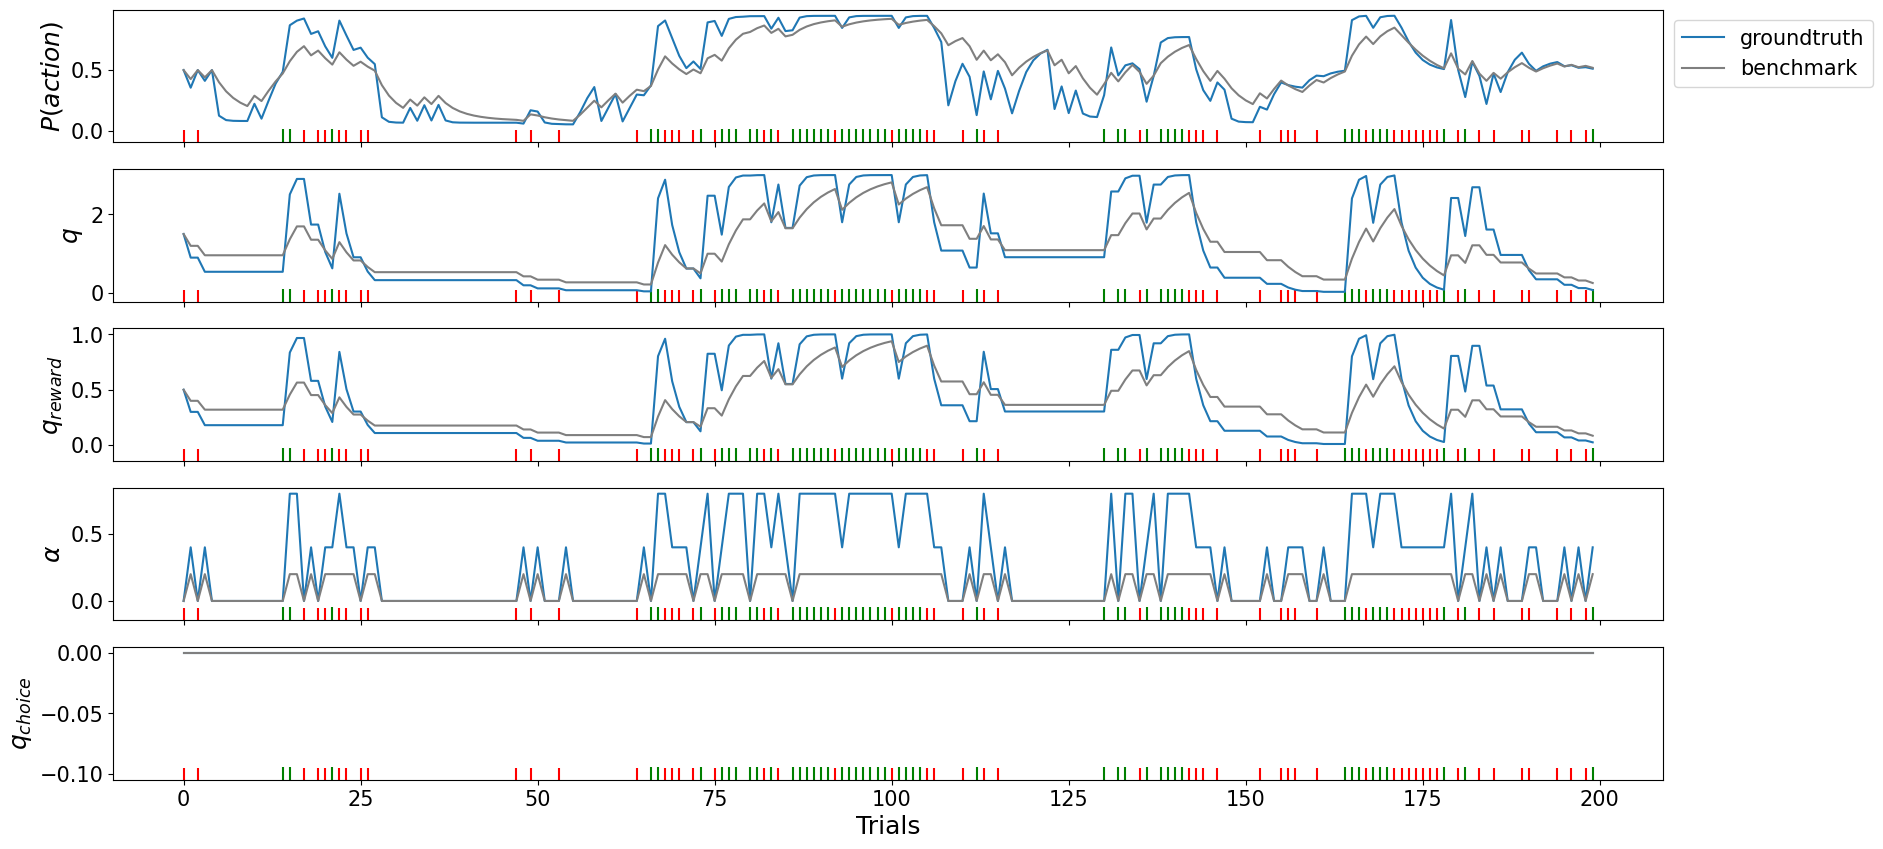

In [17]:
# Let's see how well the dynamics were fitted
agents = {'groundtruth': agent_1, 'benchmark': agent_2}
fig, axs = plot_session(agents, dataset.xs[0])

plt.show()

Can you see the stabilizing behavior in the case of unexpected penalties?

Let's inspect first how our last RNN would perform in such a situation to verify the need for tackling individual differences with a participant-embedding layer.

In [6]:
model_rnn = RLRNN(n_actions=n_actions, list_signals=list_rnn_modules+list_control_parameters)
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=5e-3)

model_rnn, _, _ = fit_model(
    model=model_rnn,
    optimizer=optimizer_rnn,
    dataset_train=dataset,
    epochs=128,
    n_steps=16,
)

# set up RNN-agent
agent_rnn = AgentNetwork(model_rnn=model_rnn, n_actions=n_actions)

# setup the SINDy-agent
agent_sindy = fit_model_sindy(
    rnn_modules=list_rnn_modules,
    control_parameters=list_control_parameters,
    agent=agent_rnn,
    data=environment,
    polynomial_degree=2,
    library_setup=library_setup,
    filter_setup=filter_setup,
    optimizer_threshold=0.05,
    optimizer_alpha=1,
    verbose=True,
)

Epoch 1/128 --- L(Training): 0.6473598; Time: 0.29s; Convergence value: 6.76e-01
Epoch 2/128 --- L(Training): 0.5664485; Time: 0.21s; Convergence value: 3.79e-01
Epoch 3/128 --- L(Training): 0.5597137; Time: 0.16s; Convergence value: 1.93e-01
Epoch 4/128 --- L(Training): 0.5569687; Time: 0.23s; Convergence value: 9.77e-02
Epoch 5/128 --- L(Training): 0.5537628; Time: 0.16s; Convergence value: 5.05e-02
Epoch 6/128 --- L(Training): 0.5512879; Time: 0.16s; Convergence value: 2.65e-02
Epoch 7/128 --- L(Training): 0.5494153; Time: 0.16s; Convergence value: 1.42e-02
Epoch 8/128 --- L(Training): 0.5478815; Time: 0.26s; Convergence value: 7.85e-03
Epoch 9/128 --- L(Training): 0.5464865; Time: 0.27s; Convergence value: 4.62e-03
Epoch 10/128 --- L(Training): 0.5451484; Time: 0.19s; Convergence value: 2.98e-03
Epoch 11/128 --- L(Training): 0.5439945; Time: 0.15s; Convergence value: 2.07e-03
Epoch 12/128 --- L(Training): 0.5429776; Time: 0.15s; Convergence value: 1.54e-03
Epoch 13/128 --- L(Traini

/home/daniel/miniconda3/envs/rl/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


Let's inspect the predictions for participant #1 first

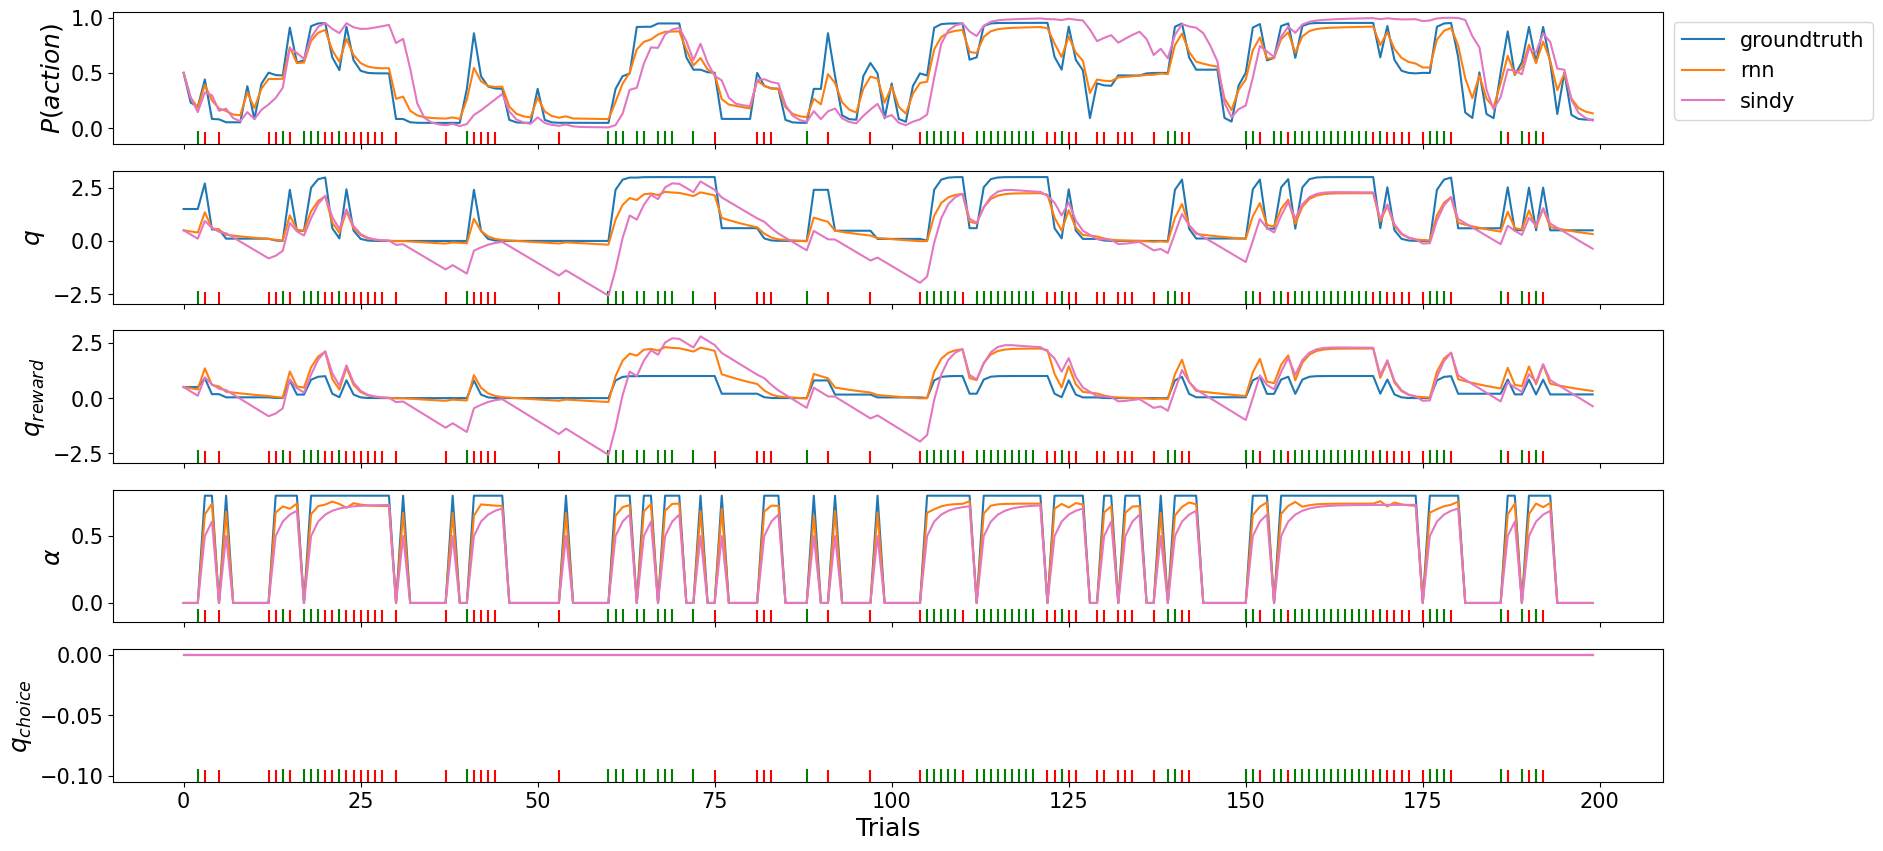

In [7]:
# Let's see how well the dynamics were fitted
agents = {'groundtruth': agent_1, 'rnn': agent_rnn, 'sindy': agent_sindy}
fig, axs = plot_session(agents, dataset_1.xs[0])
plt.show()

And now for participant #2

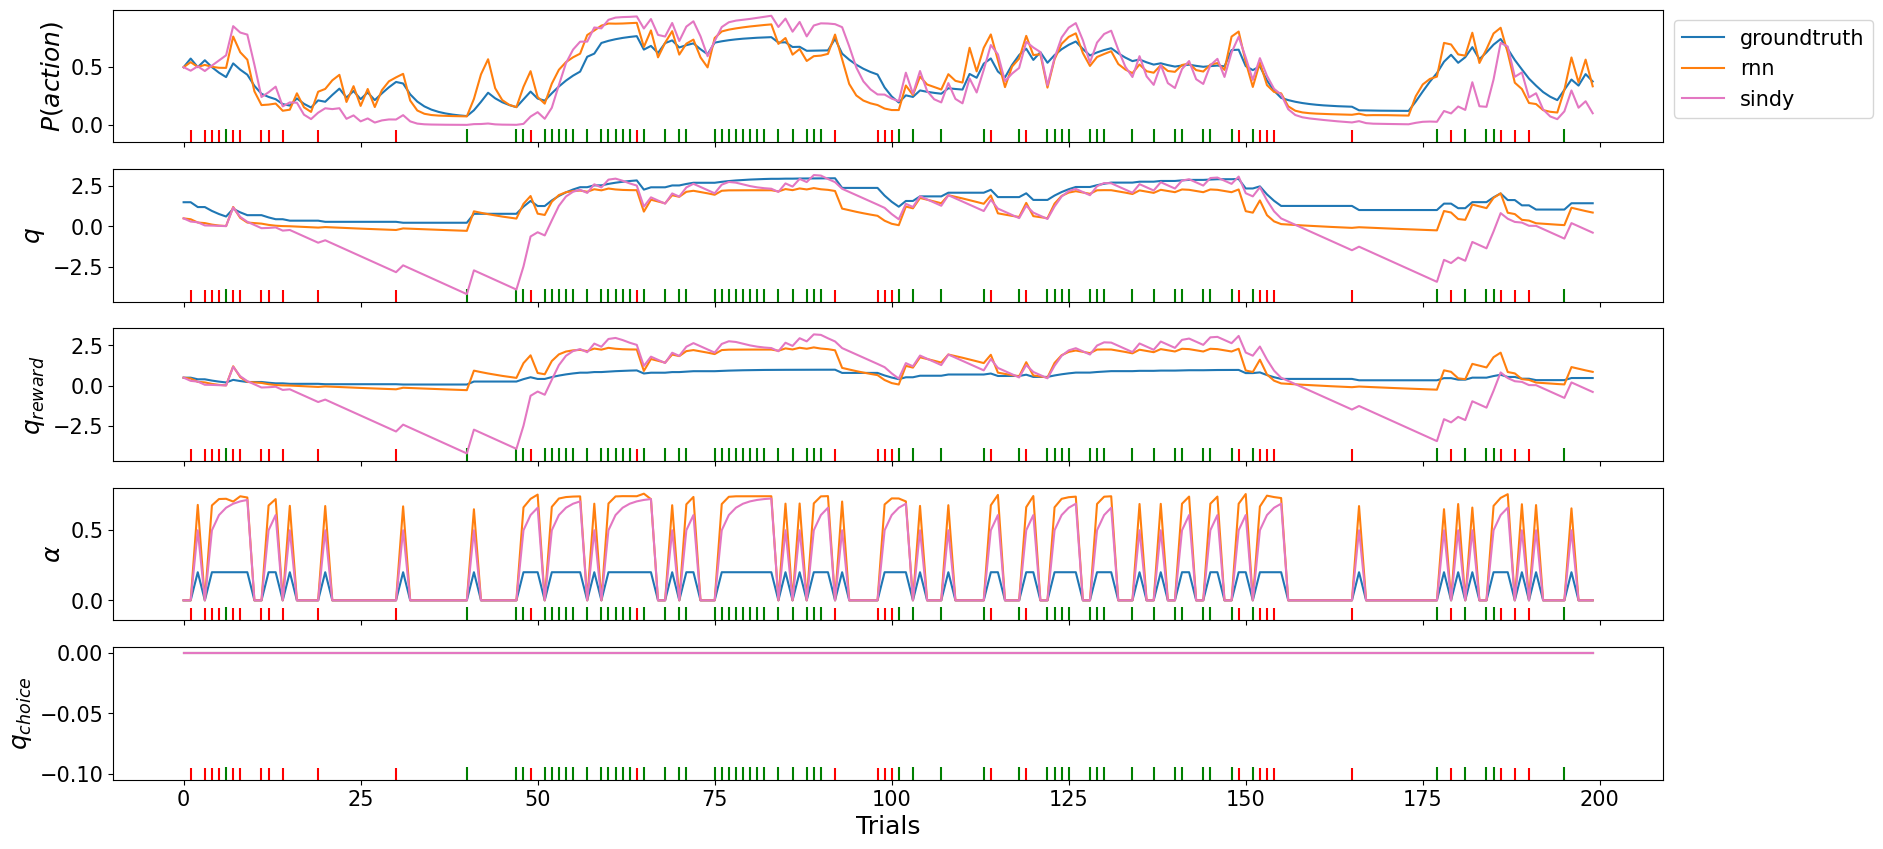

In [8]:
# Let's see how well the dynamics were fitted
agents = {'groundtruth': agent_2, 'rnn': agent_rnn, 'sindy': agent_sindy}
fig, axs = plot_session(agents, dataset_2.xs[0])
plt.show()

The fit across both participants is  worse compared to the other use-cases, where we had only one participant to fit. 

Therefore, we can definitely see the need for modeling individual differences - already in this case. The need is even stronger for real datasets with dozens of participants.  

Let's implement now a RNN which can be trained on the whole dataset but account for the differences in the individual's behavior.

For that we are going to add a participant-embedding layer. It works similar to e.g. word-embeddings which translate a one-hot encoded vector into a dense representation in a multidimensional space.

The one-hot encoded vector corresponds to e.g. a dictionary marking the index of a certain word. After translating this word into the multidimensional space, researchers can do inference on word similarity or try to interpret the representation and extract characteristics from it.

We are making use of the embedding layer by passing a unique participant id into it and retrieve a dense representation of this participant being unique to them. Afterwards we can feed this representation to the RNN-modules or compute individual noise temperatures.

That way the RNN-modules can learn any type of cognitive mechanism present in the data across all participants and the participant-embedding can give the individual notions to them by e.g. switching mechanisms on and off and parameterizing them.

In [ ]:
class RLRNN(BaseRNN):
    
    init_values = {
            'x_value_reward': 0.5,
            'x_learning_rate_reward': 0,
        }
    
    def __init__(
        self,
        n_actions,
        # add an additional inputs to set the number of participants in your data
        n_participants,
        list_signals,
        **kwargs,
    ):
        
        super(RLRNN, self).__init__(n_actions=n_actions, list_signals=list_signals)
        
        # specify here the participant-specifc parts
        self.embedding_size = 8
        self.participant_embedding = torch.nn.Embedding(num_embeddings=n_participants, embedding_dim=self.embedding_size)
        
        # and now we are adding for each participant a scaling factor (inverse noise temperature).
        # but this time, we want to use the participant embedding as an input
        self.betas = torch.nn.ModuleDict()
        self.betas['x_value_reward'] = torch.nn.Sequential(torch.nn.Linear(self.embedding_size, 1), torch.nn.ReLU())
        
        # and here we specify the general architecture
        # add to the input_size the embedding_size as well because we are going to pass the participant-embedding to the RNN-modules
        # set up the submodules
        self.submodules_rnn['x_learning_rate_reward'] = self.setup_module(input_size=2+self.embedding_size, dropout=0.)
        self.submodules_rnn['x_value_reward_not_chosen'] = self.setup_module(input_size=0+self.embedding_size, dropout=0.)
        
        # set up hard-coded equations
        # add here a RNN-module in the form of an hard-coded equation to compute the update for the chosen reward-based value
        self.submodules_eq['x_value_reward_chosen'] = lambda value, inputs: value + inputs[..., 1] * (inputs[..., 0] - value)
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, participant_id = inputs
        
        # Here we compute now the participant embeddings for each entry in the batch
        participant_embedding = self.participant_embedding(participant_id[0, :, 0].int())
        beta_value_reward = self.betas['x_value_reward'](participant_embedding)
        
        for timestep, action, reward in zip(timesteps, actions, rewards):
            
            learning_rate_reward = self.call_module(
                key_module='x_learning_rate_reward',
                key_state='x_learning_rate_reward',
                action=action,
                inputs=(reward, self.state['x_value_reward']),
                # add participant-embedding (for RNN-modules) and participant-index (later for SINDy-modules) 
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                activation_rnn=torch.nn.functional.sigmoid,
            )
            
            # Let's perform the belief update for the reward-based value of the chosen option            
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward_chosen',
                key_state='x_value_reward',
                action=action,
                inputs=(reward, learning_rate_reward),
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                )
            
            # Update of the not-chosen reward-based value
            next_value_reward_not_chosen = self.call_module(
                key_module='x_value_reward_not_chosen',
                key_state='x_value_reward',
                action=1-action,
                inputs=None,
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                )
            
            self.state['x_value_reward'] = next_value_reward_chosen * beta_value_reward + next_value_reward_not_chosen
            self.state['x_learning_rate_reward'] = learning_rate_reward
            
            # Now keep track of this value in the output array
            logits[timestep] = self.state['x_value_reward']
            
            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
            self.record_signal('c_value_reward', self.state['x_value_reward'])
        
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        logits = self.post_forward_pass(logits, batch_first)
        
        return logits, self.get_state()

In [19]:
# get the number of participants from your data
participant_ids = dataset.xs[..., -1].unique()
n_participants = len(participant_ids)
model_rnn = RLRNN(n_actions=n_actions, n_participants=n_participants, list_signals=list_rnn_modules+list_control_parameters)
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=5e-3)

model_rnn, _, _ = fit_model(
    model=model_rnn,
    optimizer=optimizer_rnn,
    dataset_train=dataset,
    epochs=2048,
    n_steps=16,
    scheduler=True,
    convergence_threshold=1e-19,
)

# set up RNN-agent
agent_rnn = AgentNetwork(model_rnn=model_rnn, n_actions=n_actions)

# setup the SINDy-agent
agent_sindy = fit_model_sindy(
    rnn_modules=list_rnn_modules,
    control_parameters=list_control_parameters,
    agent=agent_rnn,
    data=environment,
    n_sessions=n_participants,
    n_trials=1024,
    polynomial_degree=2,
    library_setup=library_setup,
    filter_setup=filter_setup,
    optimizer_threshold=0.05,
    optimizer_alpha=0.1,
    verbose=True,
)

Epoch 1/2048 --- L(Training): 0.6380040; Time: 0.17s; Convergence value: 6.81e-01; LR: 0.00e+00
Epoch 2/2048 --- L(Training): 0.6266692; Time: 0.21s; Convergence value: 3.46e-01; LR: 1.95e-05
Epoch 3/2048 --- L(Training): 0.6261983; Time: 0.18s; Convergence value: 1.73e-01; LR: 3.91e-05
Epoch 4/2048 --- L(Training): 0.6252482; Time: 0.17s; Convergence value: 8.71e-02; LR: 5.86e-05
Epoch 5/2048 --- L(Training): 0.6239171; Time: 0.17s; Convergence value: 4.42e-02; LR: 7.81e-05
Epoch 6/2048 --- L(Training): 0.6223437; Time: 0.17s; Convergence value: 2.29e-02; LR: 9.77e-05
Epoch 7/2048 --- L(Training): 0.6206843; Time: 0.20s; Convergence value: 1.23e-02; LR: 1.17e-04
Epoch 8/2048 --- L(Training): 0.6190947; Time: 0.23s; Convergence value: 6.94e-03; LR: 1.37e-04
Epoch 9/2048 --- L(Training): 0.6177083; Time: 0.25s; Convergence value: 4.16e-03; LR: 1.56e-04
Epoch 10/2048 --- L(Training): 0.6166139; Time: 0.26s; Convergence value: 2.63e-03; LR: 1.76e-04
Epoch 11/2048 --- L(Training): 0.615841

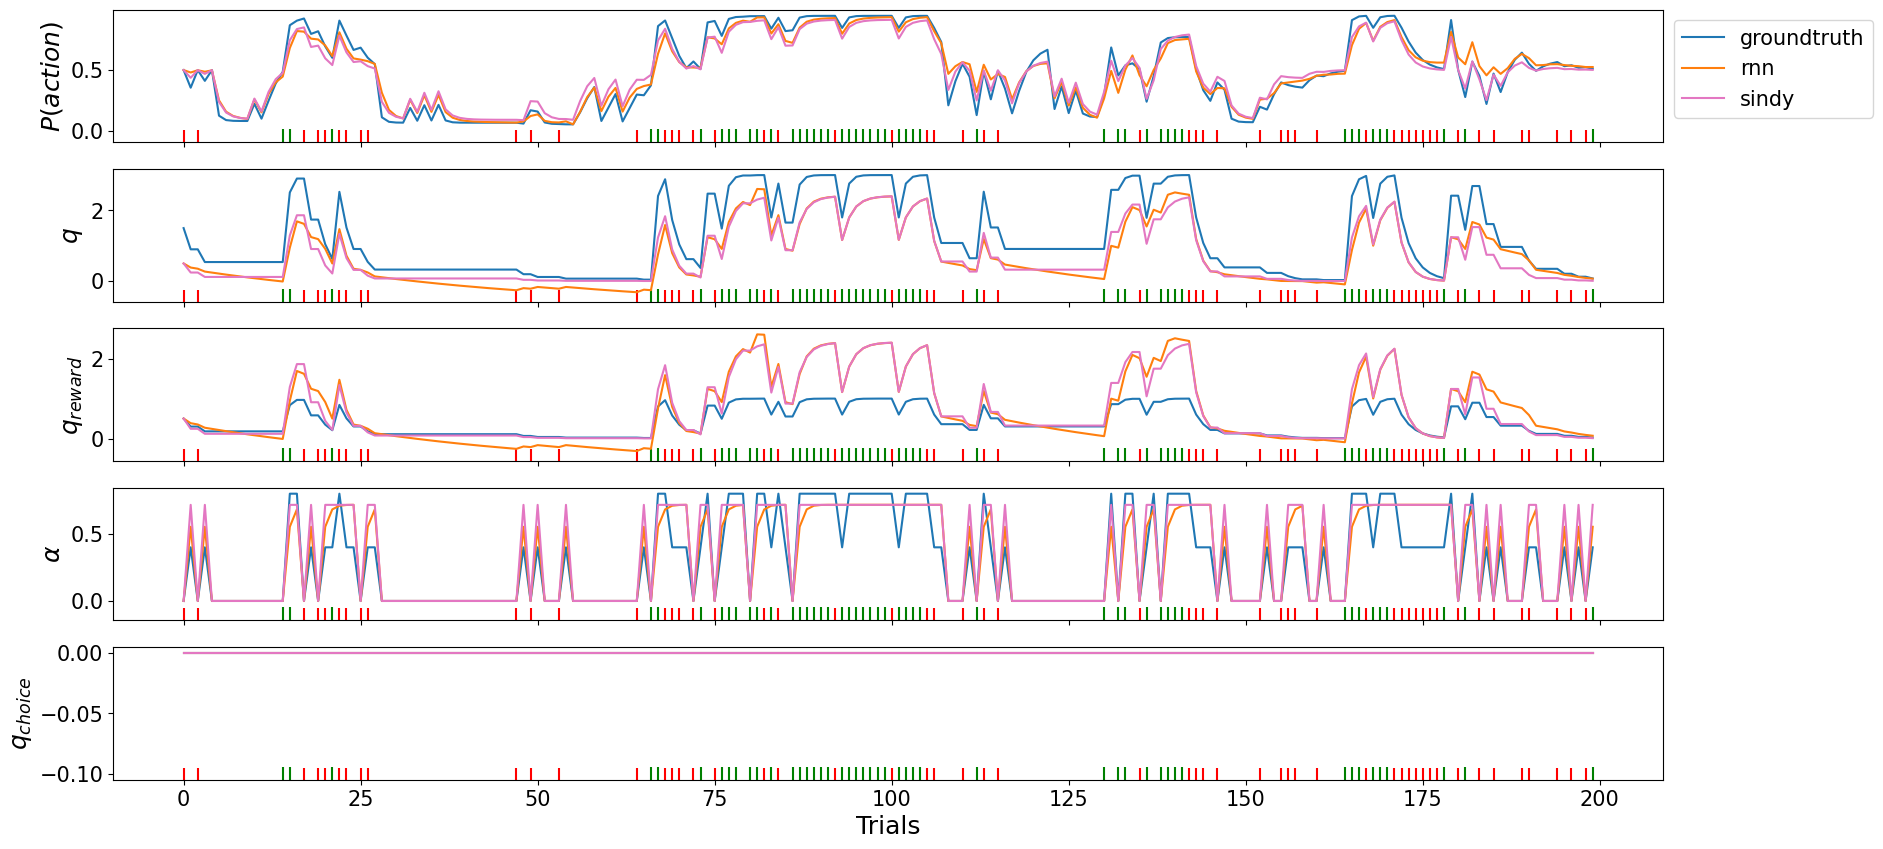

In [20]:
# Let's see how well the dynamics were fitted
agents = {'groundtruth': agent_1, 'rnn': agent_rnn, 'sindy': agent_sindy}
fig, axs = plot_session(agents, dataset_1.xs[0])

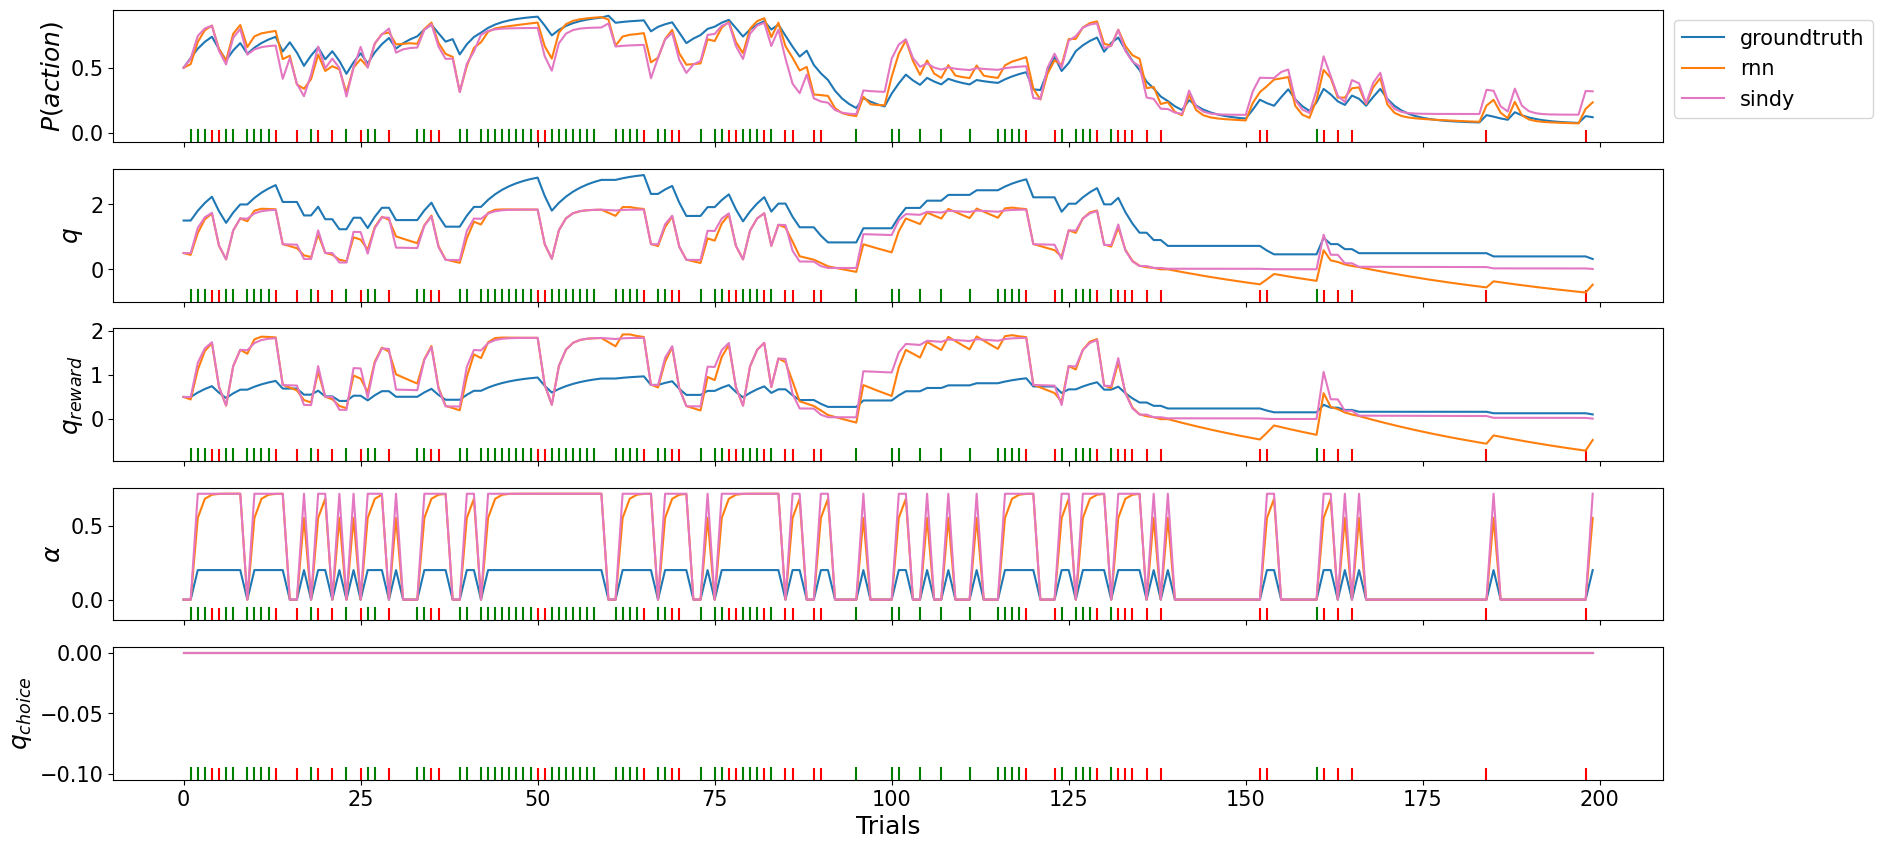

In [21]:
# Let's see how well the dynamics were fitted
agents = {'groundtruth': agent_2, 'rnn': agent_rnn, 'sindy': agent_sindy}
fig, axs = plot_session(agents, dataset_2.xs[0])

## Setting up the SOTA-RNN from Weinhardt et al (2025)

In this section we are going to set up the RNN as implemented by Weinhardt et al (2025).

This RNN includes RNN-modules for approximating goal-directed behavior (`x_value_reward`) as well non-goal-directed behavior (`x_value_choice`).

Our synthetic participant has the parameters `beta_choice` and `alpha_choice`, which are handling the non-goal-directed behavior in the form of a choice-perseverance bias.

This choice-perseverance bias makes the participant prefer to repeat previously chosen actions by increasing `x_value_choice` if chosen previously and decreasing if not chosen anymore.

For that we are going to follow these steps:

1. add the new memory-state value `x_value_choice` in `init_values`
2. add new RNN-modules to process `x_value_choice` -> `x_value_choice_chosen` and `x_value_choice_chosen`
3. adapt the forward-method

    3.1 handle the calls of the new RNN-modules

    3.2 add the updated value `x_value_choice` to the logit

4. adjust the SINDy-configuration accordingly

We are going to keep here the participant-embedding even though we are not going to simulate different agents. We just have to make sure to set the participant-IDs in the dataset to `0`.

In [ ]:
class RLRNN(BaseRNN):
    
    init_values = {
            'x_value_reward': 0.5,
            'x_value_choice': 0.,
            'x_learning_rate_reward': 0.,
        }
    
    def __init__(
        self,
        n_actions,
        n_participants,
        list_signals,
        **kwargs,
    ):
        
        super(RLRNN, self).__init__(n_actions=n_actions, list_signals=list_signals)
        
        # set up the participant-embedding layer
        self.embedding_size = 8
        self.participant_embedding = torch.nn.Embedding(num_embeddings=n_participants, embedding_dim=self.embedding_size)
        
        # scaling factor (inverse noise temperature) for each participant for the values which are handled by an hard-coded equation
        self.betas = torch.nn.ModuleDict()
        self.betas['x_value_reward'] = torch.nn.Sequential(torch.nn.Linear(self.embedding_size, 1), torch.nn.ReLU())
        
        # set up the submodules
        self.submodules_rnn['x_learning_rate_reward'] = self.setup_module(input_size=2+self.embedding_size, dropout=0.)
        self.submodules_rnn['x_value_reward_not_chosen'] = self.setup_module(input_size=0+self.embedding_size, dropout=0.)
        self.submodules_rnn['x_value_choice_chosen'] = self.setup_module(input_size=0+self.embedding_size, dropout=0.)
        self.submodules_rnn['x_value_choice_not_chosen'] = self.setup_module(input_size=0+self.embedding_size, dropout=0.)
        
        # set up hard-coded equations
        self.submodules_eq['x_value_reward_chosen'] = lambda value, inputs: value + inputs[..., 1] * (inputs[..., 0] - value)
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, participant_id = inputs
        
        # Here we compute now the participant embeddings for each entry in the batch
        participant_embedding = self.participant_embedding(participant_id[0, :, 0].int())
        beta_value_reward = self.betas['x_value_reward'](participant_embedding)
        
        for timestep, action, reward in zip(timesteps, actions, rewards):
            
            # updates for x_value_reward
            learning_rate_reward = self.call_module(
                key_module='x_learning_rate_reward',
                key_state='x_learning_rate_reward',
                action=action,
                inputs=(reward, self.state['x_value_reward']),
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                activation_rnn=torch.nn.functional.sigmoid,
            )
            
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward_chosen',
                key_state='x_value_reward',
                action=action,
                inputs=(reward, learning_rate_reward),
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                )
            
            next_value_reward_not_chosen = self.call_module(
                key_module='x_value_reward_not_chosen',
                key_state='x_value_reward',
                action=1-action,
                inputs=None,
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                )
            
            # updates for x_value_choice
            next_value_choice_chosen = self.call_module(
                key_module='x_value_choice_chosen',
                key_state='x_value_choice',
                action=action,
                inputs=None,
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                )
            
            next_value_choice_not_chosen = self.call_module(
                key_module='x_value_choice_not_chosen',
                key_state='x_value_choice',
                action=1-action,
                inputs=None,
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                )
            
            # updating the memory state
            self.state['x_learning_rate_reward'] = learning_rate_reward
            self.state['x_value_reward'] = next_value_reward_chosen * beta_value_reward + next_value_reward_not_chosen
            self.state['x_value_choice'] = next_value_choice_chosen + next_value_choice_not_chosen
            
            # Now keep track of the logit in the output array
            logits[timestep] = self.state['x_value_reward'] + self.state['x_value_choice']
            
            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
            self.record_signal('c_value_reward', self.state['x_value_reward'])
        
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        logits = self.post_forward_pass(logits, batch_first)
        
        return logits, self.get_state()

In [46]:
# SINDy configuration
# Add already here the new module and update the library and filter setup.
list_rnn_modules = ['x_learning_rate_reward', 'x_value_reward_not_chosen', 'x_value_choice_chosen', 'x_value_choice_not_chosen']

# add here a control parameter for the reward-based value which serves as an additional input to the learning-rate
list_control_parameters = ['c_action', 'c_reward', 'c_value_reward']

# The new module which handles the not-chosen value, does not need any additional inputs except for the value
library_setup = {
    # 'x_value_reward_chosen': ['c_reward'] -> Remove this one from the library as we are not going to identify the dynamics of a hard-coded equation
    'x_learning_rate_reward': ['c_reward', 'c_value_reward'],
    'x_value_reward_not_chosen': [],
    'x_value_choice_chosen': [],
    'x_value_choice_not_chosen': [],
    }

# Further, the new module should be applied only to the not-chosen values
filter_setup = {
    # 'x_value_reward_chosen': ['c_action', 1, True], -> Remove this one as well
    'x_learning_rate_reward': ['c_action', 1, True],
    'x_value_reward_not_chosen': ['c_action', 0, True],
    'x_value_choice_chosen': ['c_action', 1, True],
    'x_value_choice_not_chosen': ['c_action', 0, True],
}

In [47]:
agent = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.5,
    alpha_penalty=0.5,
    forget_rate=0.,
    confirmation_bias=0.,
    beta_choice=1.,
    alpha_choice=1.,
)

dataset, _, _ = create_dataset(
    agent=agent,
    environment=environment,
    n_trials=n_trials,
    n_sessions=n_sessions,
)

# set participant ids to 0
dataset.xs[..., -1] = 0.

In [50]:
model_rnn = RLRNN(n_actions=n_actions, n_participants=1, list_signals=list_rnn_modules+list_control_parameters)
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=5e-3)

model_rnn, _, _ = fit_model(
    model=model_rnn,
    optimizer=optimizer_rnn,
    dataset_train=dataset,
    epochs=256,
    n_steps=16,
    scheduler=False,
    convergence_threshold=1e-19,
)

# set up RNN-agent
agent_rnn = AgentNetwork(model_rnn=model_rnn, n_actions=n_actions)

# setup the SINDy-agent
agent_sindy = fit_model_sindy(
    rnn_modules=list_rnn_modules,
    control_parameters=list_control_parameters,
    agent=agent_rnn,
    data=environment,
    n_sessions=1,
    n_trials=1024,
    polynomial_degree=2,
    library_setup=library_setup,
    filter_setup=filter_setup,
    optimizer_threshold=0.05,
    optimizer_alpha=0.1,
    verbose=True,
)

Epoch 1/256 --- L(Training): 5.1922918; Time: 0.39s; Convergence value: 2.60e+00
Epoch 2/256 --- L(Training): 1.6970753; Time: 0.40s; Convergence value: 3.05e+00
Epoch 3/256 --- L(Training): 0.6672087; Time: 0.34s; Convergence value: 2.04e+00
Epoch 4/256 --- L(Training): 0.4076721; Time: 0.38s; Convergence value: 1.15e+00
Epoch 5/256 --- L(Training): 0.3976671; Time: 0.30s; Convergence value: 5.79e-01
Epoch 6/256 --- L(Training): 0.3897536; Time: 0.31s; Convergence value: 2.94e-01
Epoch 7/256 --- L(Training): 0.3872543; Time: 0.32s; Convergence value: 1.48e-01
Epoch 8/256 --- L(Training): 0.3855625; Time: 0.31s; Convergence value: 7.49e-02
Epoch 9/256 --- L(Training): 0.3837700; Time: 0.46s; Convergence value: 3.83e-02
Epoch 10/256 --- L(Training): 0.3822876; Time: 0.30s; Convergence value: 1.99e-02
Epoch 11/256 --- L(Training): 0.3809186; Time: 0.40s; Convergence value: 1.06e-02
Epoch 12/256 --- L(Training): 0.3795651; Time: 0.34s; Convergence value: 6.00e-03
Epoch 13/256 --- L(Traini

/home/daniel/miniconda3/envs/rl/lib/python3.11/site-packages/pysindy/optimizers/sr3.py:390: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.0162e-26 ... 2.5000e-02 ... 2.5000e-02 ... 2.7500e-02
         3 ... 1.0400e-02 ... 2.8100e-02 ... 2.2524e-02 ... 3.5734e-02
         6 ... 1.1608e-02 ... 2.8448e-02 ... 2.2388e-02 ... 3.6840e-02
         9 ... 1.1678e-02 ... 2.8468e-02 ... 2.2380e-02 ... 3.6905e-02
        12 ... 1.1681e-02 ... 2.8469e-02 ... 2.2380e-02 ... 3.6908e-02
(x_value_reward_not_chosen)[k+1] = 1.000 x_value_reward_not_chosen[k]

SINDy model for x_value_choice_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 5.4574e-07 ... 1.2500e-01 ... 1.8317e-01 ... 1.9567e-01
         3 ... 4.9346e-05 ... 1.2500e-01 ... 1.5686e-01 ... 1.6941e-01
         6 ... 1.9551e-04 ... 1.2500e-01 ... 1.3055e-01 ... 1.4325e-01
         9 ... 4.3884e-04 ... 1.2500e-01 ... 1.0424e-01 ... 1.1718e-01
        12 ... 7.7917e-04 ... 1.2500e-01 ... 7.79

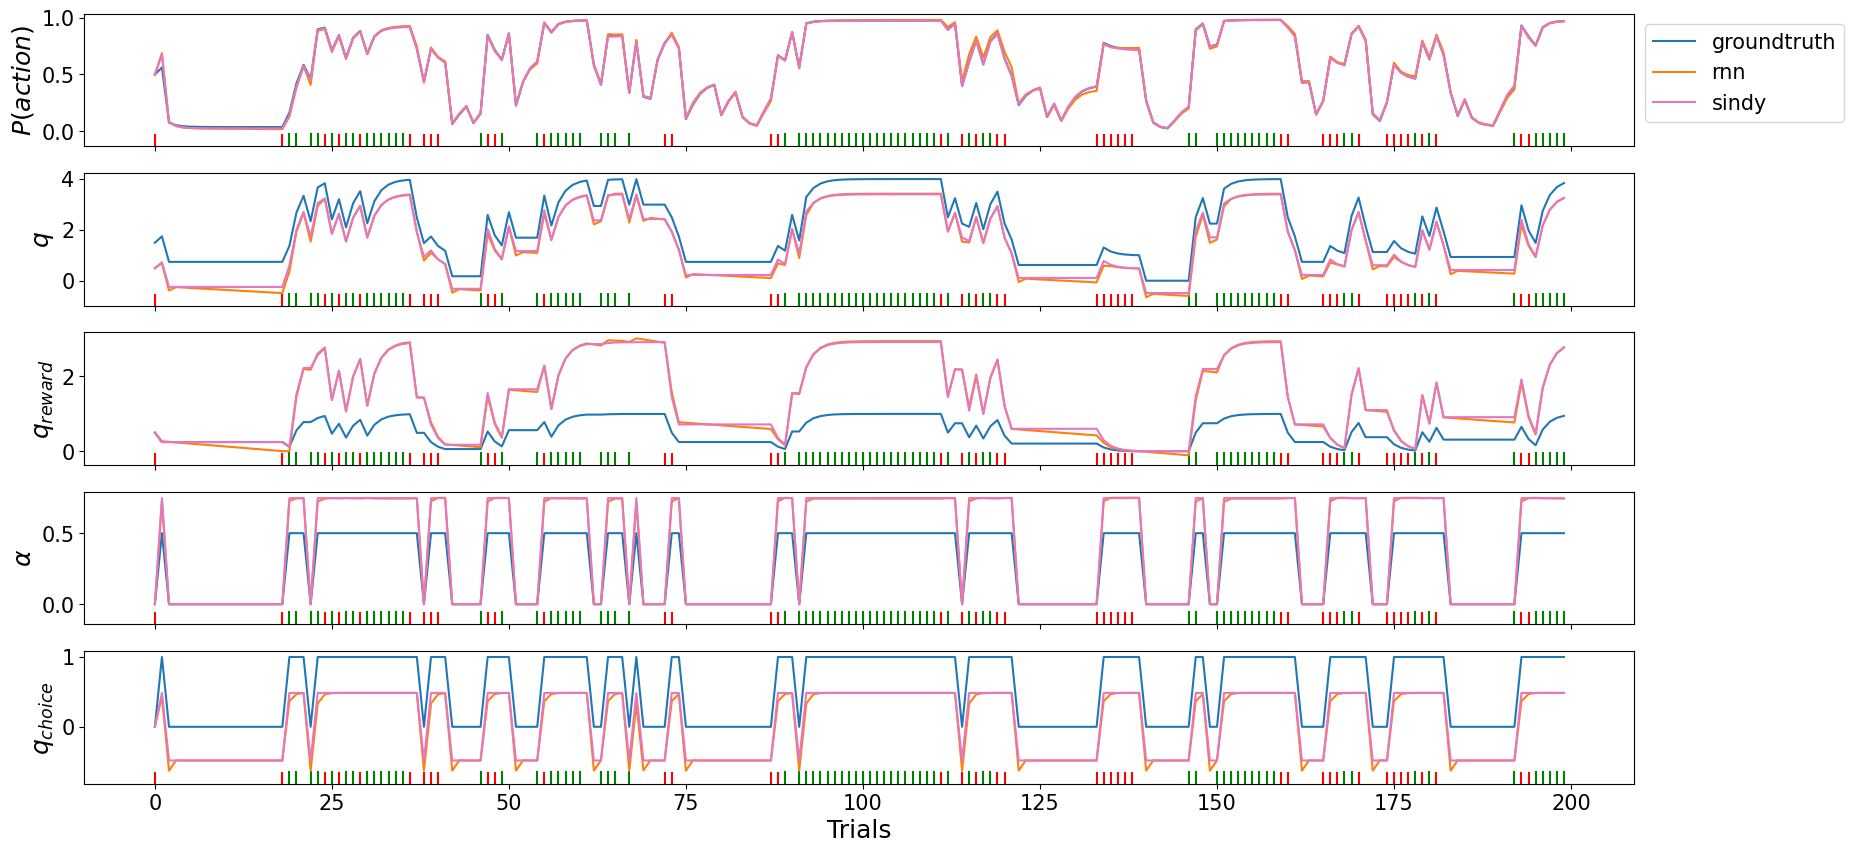

In [51]:
# Let's see how well the dynamics were fitted
agents = {'groundtruth': agent, 'rnn': agent_rnn, 'sindy': agent_sindy}
fig, axs = plot_session(agents, dataset.xs[0])